<a href="https://colab.research.google.com/github/apoorvyadav1111/medium-data-science/blob/master/Content_Based_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content Based Recommender System

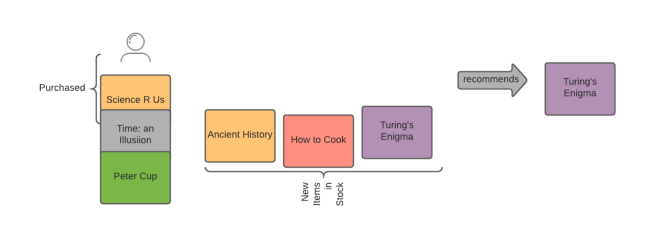

These systems use characteristics information of user and item/product. If a user was interested in a product in the past, They will probably be interested in the future. We can group items based on the similarities and use them as a candidate. You might have seen these in your e-commerce shopping apps, when you click on a product, you have 10–12 similar at the bottom.

Let us load the libraries required for the system


In [ ]:
#load the libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Getting the MovieLens Dataset

We are using the movielens dataset for this guide. The zip contains the following files.

1.  movies.csv - movie id, name and genres associated
2.  links.csv - contain values to link movies to other sources
3.  ratings.csv - records of rating by user(id) for movie(id)
4.  tags.csv - metadata about movies(id) provided by user(id)
5.  genome-tags.csv - contains list all tags with unique identifiers
6.  genome-scores.csv - contains relevance score for a movie wrt a tag









In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

--2020-10-25 14:09:14--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  16.9MB/s    in 17s     

2020-10-25 14:09:32 (15.8 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


## Load Data into Pandas DataFrame and have a look

In [ ]:
links = pd.read_csv('ml-latest/links.csv')
movies = pd.read_csv('ml-latest/movies.csv')
ratings = pd.read_csv('ml-latest/ratings.csv')
tags = pd.read_csv('ml-latest/tags.csv')
genome_tags = pd.read_csv('ml-latest/genome-tags.csv')
genome_scores = pd.read_csv('ml-latest/genome-scores.csv')

In [ ]:
# we can observe that this df contains following data:
# Movie Name
# its unique identifier - movieId useful accross the Dataset
# Genres: Genres associated with the movie

movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
# This DF contains:
# userId: Uniquer Identifier useful across the dataset
# movieId
# tag specified by that user to this movie
# timestamp: time at which user assigned this tag

tags.head(2)

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532


In [ ]:
# This is the ratings df containing following features
# userId rating the movie
# movieId
# Rating provied by user. A decimal number from 1..5
# timestamp: time at which user rated the movie

ratings.head(2)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456


In [ ]:
# The DF genome_scores contains processed data provived in hand containing relevance of a tag associated with a movie
# we can understand it by taking an example.
# A tag associated to a Horror movie: 
# Thriller: can have high relevance with value closer to 1 e.g. 0.67, 0.89 etc
# Comedy: can high smaller value of relevance like 0.001, 0.2 etc

genome_scores.head(2)

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375


In [ ]:
# This DF contains all the tags and tagId assigned by all the users

genome_tags.head(2)

,tagId,tag
0,1,007
1,2,007 (series)


In [ ]:
# This DF contains data for external links for the movie
# This is not so useful to use right now. 
# However we can use these to gather more data per movie incase one choose to 
# research more on it.
# get more data:
# From movie lens: https://movielens.org/movies/<movieId>
# from Imdb: https://www.imdb.com/title/tt<imdbId>
# from tmdb: https://www.themoviedb.org/movie/<tmdbId>

links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


## Prep Data

As you can observe the data is fairly divided and an individual DF is not so meaningful by itself.
We will try to get all the important features under one roof.

In [ ]:
# Taking associated tags with only moderate relevance
# You can change and try with other values such as 0 and 0.5
THRESH_RELAVANCE = 0.3

In [ ]:
movie_tags = genome_scores[genome_scores.relevance>THRESH_RELAVANCE][['movieId','tagId']] # we do not need the relevance further
movie_tags.head(2)

,movieId,tagId
10,1,11
18,1,19


#### Let's Try to relate the data across the DF with just one movie id

In [ ]:
# Set you movieId here and run the following cells
MID = 1

In [ ]:
# what is the movie name and genres for the movie id?
movies[movies.movieId == MID]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
# What are the tags given by the users to this movie?
# joining textual names genome_tags with movie_tags so to get a context

movie_tags[movie_tags.movieId == MID].merge(genome_tags,on='tagId')

,movieId,tagId,tag
0,1,11,3d
1,1,19,action
2,1,21,adaptation
3,1,22,adapted from:book
4,1,29,adventure
...,...,...,...
181,1,1092,visually stunning
182,1,1093,visuals
183,1,1104,weird
184,1,1108,whimsical


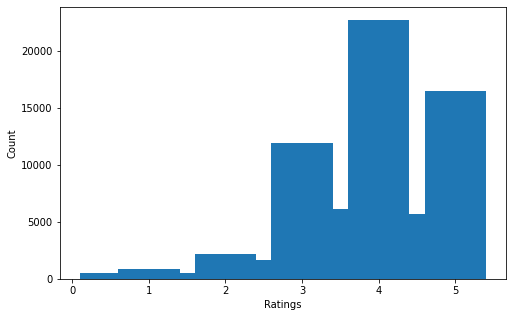

In [ ]:
import matplotlib.pyplot as plt

# Want to get ratings for this movie or the rating's distribution?
dist = ratings[ratings.movieId == MID].rating.value_counts()
dist = dist.reset_index()
plt.figure(figsize=(8,5))
plt.bar(dist['index'],dist.rating)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

## Let's Start with Merging all the data to creating something meaningful

In [ ]:
movie_tags = pd.merge(movie_tags,genome_tags,on='tagId',how='left')[['movieId','tagId']]
movie_tags['tagId'] = movie_tags.tagId.astype(str)

In [ ]:
# This function will help us to gather all the tags associated with a movie under one roof as a string
# It will be applied as an aggregate function
def _concatenate_tags_of_movie(tags):
  tags_as_str = ' '.join(set(tags))
  return tags_as_str

In [ ]:
movie_all_tags = movie_tags.groupby('movieId')['tagId'].agg(_concatenate_tags_of_movie)       # Concating all the tags into one
movie_all_tags.name = 'movie_tags'                                                            # Renaming the column
movie_all_tags = movie_all_tags.reset_index()

In [ ]:
# Let's have a look for our MID
movie_all_tags[movie_all_tags.movieId==MID]['movie_tags']

0    897 1090 990 1104 230 220 94 113 63 748 454 36...
Name: movie_tags, dtype: object

In [ ]:
# Let's take some data from ratings df. 
# Since we can't take all the ratings, we can take mean, median,mode and size for a movie rating

avg_ratings = ratings.groupby('movieId')['rating'].agg(['mean','median',pd.Series.mode,'size'])
avg_ratings.columns = ['ratings_mean','ratings_median','ratings_mode','num_ratings']
avg_ratings.reset_index(inplace=True)
avg_ratings.head()

,movieId,ratings_mean,ratings_median,ratings_mode,num_ratings
0,1,3.886649,4.0,4,68469
1,2,3.246583,3.0,3,27143
2,3,3.173981,3.0,3,15585
3,4,2.874540,3.0,3,2989
4,5,3.077291,3.0,3,15474


In [ ]:
# Adding the rating statistics and concatenated tags we calculated with movies DF

movies_with_ratings = pd.merge(movies,avg_ratings,on='movieId',how='left')      # Movies + Rating Stats = Movie_with_Ratings
data = pd.merge(movies_with_ratings,movie_all_tags,on='movieId',how='left')     # Movies_with_Ratings + All_Tags = Data
data.head(2)

,movieId,title,genres,ratings_mean,ratings_median,ratings_mode,num_ratings,movie_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649,4.0,4,68469.0,897 1090 990 1104 230 220 94 113 63 748 454 36...
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.246583,3.0,3,27143.0,1090 1104 230 604 220 113 953 454 378 742 266 ...


In [ ]:
# Around 13000 movies have tags associated with them.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58098 entries, 0 to 58097
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         58098 non-null  int64  
 1   title           58098 non-null  object 
 2   genres          58098 non-null  object 
 3   ratings_mean    53889 non-null  float64
 4   ratings_median  53889 non-null  float64
 5   ratings_mode    53889 non-null  object 
 6   num_ratings     53889 non-null  float64
 7   movie_tags      13176 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.0+ MB


In [ ]:
# removing movies having no tags
tagged_data = data[~data.movie_tags.isnull()].reset_index(drop=True)

In [ ]:
tagged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13176 entries, 0 to 13175
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         13176 non-null  int64  
 1   title           13176 non-null  object 
 2   genres          13176 non-null  object 
 3   ratings_mean    13176 non-null  float64
 4   ratings_median  13176 non-null  float64
 5   ratings_mode    13176 non-null  object 
 6   num_ratings     13176 non-null  float64
 7   movie_tags      13176 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 823.6+ KB


## Encoding Data with TD-IDF

In [ ]:
#                          TF IDF                                    #
# To understand this one, we can split this into two: TF & IDF.      #
# TF as the name suggests is the frequency of a term in a document.  #
# This term alone cannot be so good since generally stop words like: #
# 'is', 'the', 'and' etc.. are mostly used. This is taken care       #
# by the IDF. This part helps to observe if the term is special to   #
# just on document or all the documents.                             #

tf_idf = TfidfVectorizer()

In [ ]:
movies_encoded = tf_idf.fit_transform(tagged_data.movie_tags)

In [ ]:
# Checking the type of the encoded movies and shape
# Shape: no. of movies x no. of tags

print(type(movies_encoded))
print(movies_encoded.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(13176, 1119)


In [ ]:
# each record in the movies encoded DF is a vector
# and to get similarity between two vectors we can use 
# various functions such as cosine similarity
# and Distance 

m2m = cosine_similarity(movies_encoded)

In [ ]:
# m2m is a DF of shape: num_movies x num_movies
# It's like a look up for similarity between two movies
m2m_df = pd.DataFrame(m2m)

In [ ]:
idx_to_movie = tagged_data['movieId']

In [ ]:
m2m_df.shape

(13176, 13176)

In [ ]:
# Changing the column names as well as index
# of the similarity dataframe with the movie id
# for ease in interopretation as well as querying

In [ ]:
m2m_df.columns = [str(idx_to_movie[int(col)]) for col in m2m_df.columns]
m2m_df.index = [str(idx_to_movie[int(idx)]) for idx in m2m_df.index ]

In [ ]:
m2m_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,180231,180265,180297,180497,180985,180987,181315,182715,182823,182825,182913,183011,183197,183227,183421,183589,183611,183619,183635,183701,183833,183897,183909,184015,184017,184239,184253,184257,184471,184931,184987,184997,185029,185135,185425,185435,185585,186587,187593,187595
1,1.000000,0.359995,0.140584,0.163904,0.197146,0.267026,0.240104,0.233925,0.075557,0.223134,0.255872,0.077303,0.325020,0.146705,0.138259,0.218560,0.241278,0.141525,0.126214,0.138313,0.243979,0.124903,0.104990,0.253165,0.245519,0.241386,0.222828,0.163651,0.243605,0.224175,0.180971,0.260051,0.148428,0.462455,0.131284,0.239041,0.264860,0.212915,0.217038,0.120549,...,0.122190,0.265750,0.271408,0.362023,0.408600,0.466373,0.217606,0.269855,0.237003,0.291993,0.313619,0.153509,0.306928,0.298205,0.251435,0.208017,0.223224,0.205067,0.143751,0.298257,0.336257,0.410174,0.269873,0.172440,0.256838,0.141836,0.247896,0.336043,0.174286,0.197509,0.231415,0.323718,0.449159,0.415062,0.115754,0.126076,0.154487,0.238729,0.376306,0.339774
2,0.359995,1.000000,0.116658,0.123059,0.119013,0.090835,0.215883,0.221415,0.167558,0.221940,0.154437,0.070224,0.162521,0.065507,0.341558,0.068640,0.108855,0.083785,0.123483,0.158100,0.105103,0.114945,0.116282,0.226777,0.058892,0.079961,0.135894,0.065802,0.237803,0.101203,0.191405,0.168100,0.167015,0.283567,0.048585,0.066479,0.257709,0.229147,0.130706,0.076284,...,0.101037,0.088160,0.093305,0.186838,0.287223,0.316128,0.053926,0.107247,0.297740,0.138888,0.251050,0.164583,0.155920,0.152377,0.152986,0.240821,0.111776,0.126296,0.131096,0.244780,0.221224,0.167060,0.189604,0.179779,0.245187,0.117279,0.220382,0.133570,0.245182,0.163609,0.309822,0.231912,0.207119,0.253158,0.151519,0.122537,0.183769,0.244879,0.204680,0.287186
3,0.140584,0.116658,1.000000,0.192486,0.407801,0.090215,0.246536,0.151995,0.077091,0.142224,0.163142,0.169911,0.076135,0.069782,0.136941,0.082496,0.192240,0.151843,0.253176,0.123903,0.128339,0.113151,0.073628,0.107878,0.079398,0.118713,0.212720,0.060971,0.056157,0.086422,0.197483,0.069226,0.112299,0.144545,0.083814,0.079071,0.156177,0.222574,0.258914,0.079760,...,0.286807,0.143155,0.137168,0.188771,0.232119,0.177072,0.086489,0.119203,0.209014,0.133169,0.170296,0.161700,0.148858,0.150423,0.124191,0.281840,0.213561,0.179050,0.158729,0.151799,0.143071,0.146023,0.223500,0.214345,0.156097,0.073496,0.175295,0.132123,0.117787,0.188265,0.118169,0.198064,0.173156,0.146563,0.090056,0.131115,0.226738,0.147758,0.202069,0.204408
4,0.163904,0.123059,0.192486,1.000000,0.278716,0.075740,0.334642,0.200485,0.049504,0.079378,0.273124,0.112765,0.100985,0.074070,0.090414,0.119454,0.310576,0.078862,0.086807,0.158112,0.091624,0.113165,0.041694,0.252197,0.176297,0.155626,0.277549,0.193152,0.041497,0.097177,0.218199,0.056417,0.153074,0.246989,0.238186,0.132498,0.186063,0.305475,0.235666,0.161005,...,0.124083,0.133068,0.176698,0.245776,0.248673,0.282589,0.094499,0.173348,0.242662,0.196039,0.156245,0.167674,0.110103,0.125084,0.138888,0.246407,0.120489,0.192530,0.143466,0.151590,0.158835,0.168986,0.187478,0.226364,0.201679,0.156319,0.178827,0.180851,0.095986,0.147981,0.151011,0.195374,0.211978,0.181477,0.214305,0.168674,0.164492,0.162263,0.170269,0.199378
5,0.197146,0.119013,0.407801,0.278716,1.000000,0.085531,0.309019,0.151632,0.067623,0.109039,0.276500,0.127960,0.136049,0.069193,0.110352,0.034396,0.220650,0.085762,0.196483,0.085862,0.088458,0.105308,0.044470,0.199219,0.118097,0.089117,0.312135,0.069248,0.039600,0.054828,0.215881,0.052130,0.154174,0.215802,0.086136,0.114149,0.123252,0.394167,0.258483,0.085183,...,0.358126,0.148862,0.122464,0.258367,0.237175,0.276559,0.053888,0.110240,0.175088,0.163320,0.189061,0.113999,0.130652,0.158099,0.085488,0.285608,0.138089,0.150792,0.157642,0.137122,0.098463,0.155687,0.154315,0.127573,0.106954,0.084734,0.147741,0.149193,0.078580,0.179661,0.147010,0.264331,0.182410,0.163857,0.117392,0.133729,0.157140,0

In [ ]:
m2m_df['1']

1         1.000000
2         0.359995
3         0.140584
4         0.163904
5         0.197146
            ...   
185435    0.126076
185585    0.154487
186587    0.238729
187593    0.376306
187595    0.339774
Name: 1, Length: 13176, dtype: float64

## Let's create a DF for 10 most similar movies

In [ ]:
# Creating a DF for faster lookup with MovieID and ten columns with name 1 to 10
# We can see the movie Id of the similar movie and then find the information from the 
# tagged_data DF
similar_movies = pd.DataFrame(index = m2m_df.index,columns=['movieId','1','2','3','4','5','6','7','8','9','10']) 

In [ ]:
# movieId for better readablity
similar_movies['movieId'] = m2m_df.index.astype(int)

In [ ]:
# Initially all the movie column from 1 to 10 are NaN
similar_movies.head(3)

,movieId,1,2,3,4,5,6,7,8,9,10
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# this piece of code will take the most similar movies using m2m_df
# then take the indexes and discard the similarity 
# since we are interested in the movie Id for now
# we know the rank of those among themselves
# and for the similarity we can use m2m_df

for x in range(len(similar_movies)):
  i = str(similar_movies.iloc[x,0])
  sim = m2m_df[i].sort_values(ascending=False)[0:10]
  sim = pd.DataFrame(sim)
  sim['movieId'] = sim.index
  l = list(sim.movieId.values)
  #print(l)
  for j in range(10):
    #print(i,j)
    similar_movies.iloc[x,j+1]= int(l[j])

In [ ]:
# Now our similar_movies df looks good
similar_movies.head(3)

,movieId,1,2,3,4,5,6,7,8,9,10
1,1,1,3114,4886,78499,2355,6377,68954,8961,50872,4306
2,2,2,46972,2429,60514,2193,2054,3615,64167,2617,3153
3,3,3,3450,30825,8969,5309,155743,4534,4621,129428,69253


In [ ]:
# Let's create a function that takes a movieId and gives a small dataframe of the similar movies
# using similar_movies df and tagged_data df

def recommended_movies(id):
  try:
    similar_movies_id = similar_movies[similar_movies.movieId==id]
    similar_movies_id = pd.DataFrame(similar_movies_id.drop(columns=['movieId'])).transpose()
    similar_movies_id.columns = ['movieId']
    similar_movies_details = pd.merge(tagged_data,similar_movies_id,on='movieId',how='inner')
    return similar_movies_details
  except:
    return "Movie did not had any tags and thus can't have recommendations yet"

In [ ]:
# Lets try for a movieId
# uncomment the one to run

recommended_movies(589) #Terminator 2
#recommended_movies(1) #Toy Story 
# recommended_movies(185434) #not found

,movieId,title,genres,ratings_mean,ratings_median,ratings_mode,num_ratings,movie_tags
0,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034,4.0,4,76451.0,1073 897 883 1090 990 891 311 1104 216 220 108...
1,541,Blade Runner (1982),Action|Sci-Fi|Thriller,4.116097,4.0,5,39441.0,1073 897 883 474 1090 1029 344 891 311 1104 77...
2,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,3.941501,4.0,4,64258.0,1073 883 474 1090 1029 891 311 1104 216 220 10...
3,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,3.994663,4.0,4,34572.0,1073 897 883 474 1090 1029 522 990 344 891 311...
4,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,3.891845,4.0,4,42254.0,1073 897 883 474 1090 1029 522 891 311 1104 21...
5,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695,4.5,5,84545.0,1073 897 883 1053 149 1090 1029 990 891 311 11...
6,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,3.599662,4.0,4,24573.0,1073 897 883 1090 891 311 1104 216 9 220 281 1...
7,3527,Predator (1987),Action|Sci-Fi|Thriller,3.646651,4.0,4,18186.0,1073 897 883 474 1090 522 990 891 1104 216 9 2...
8,6537,Terminator 3: Rise of the Machines (2003),Action|Adventure|Sci-Fi,3.064633,3.0,3,12393.0,1090 220 1084 281 94 913 672 429 364 378 825 2...
9,111759,Edge of Tomorrow (2014),Action|Sci-Fi|IMAX,3.938495,4.0,4,11999.0,1073 897 883 1090 1029 990 891 311 1104 216 23...


## Building User Profiles for the recommendation

In [ ]:
ratings = pd.read_csv('ml-latest/ratings.csv')

In [ ]:
# Check out the ratings df 
# for user id = 1 
# what movies that user liked or rated and when

ratings_for_1 = ratings[ratings.userId==1]
print("User rated total {} movies".format(ratings_for_1.shape[0]))
ratings_for_1.head()

User rated total 16 movies


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [ ]:
# Getting movie details along with user ratings
# Normalizing the rating by dividing it by 5

user_data_with_tags = tagged_data.reset_index().merge(ratings_for_1,on='movieId')
user_data_with_tags['weight'] = user_data_with_tags['rating']/5.
user_data_with_tags.head()

,index,movieId,title,genres,ratings_mean,ratings_median,ratings_mode,num_ratings,movie_tags,userId,rating,timestamp,weight
0,294,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,3.971727,4.0,4,7958.0,1073 897 883 474 1090 411 1104 216 771 846 189...,1,3.5,1256677221,0.7
1,461,481,Kalifornia (1993),Drama|Thriller,3.339241,3.0,3,6037.0,1073 897 854 1034 474 731 311 1104 216 846 220...,1,3.5,1256677456,0.7
2,991,1091,Weekend at Bernie's (1989),Comedy,2.806207,3.0,3,6138.0,658 1104 230 9 1084 510 879 913 825 742 702 26...,1,1.5,1256677471,0.3
3,1134,1257,Better Off Dead... (1985),Comedy|Romance,3.828617,4.0,4,5902.0,1073 1053 1090 770 1104 216 230 846 9 220 1010...,1,4.5,1256677460,0.9
4,1310,1449,Waiting for Guffman (1996),Comedy,3.918378,4.0,4,6867.0,1073 897 311 770 1104 230 771 220 879 113 551 ...,1,4.5,1256677264,0.9


In [ ]:
# This piece of code does the following
# remember the encoding we did before
# now we got those encoding for the movies our user rated and 
# got a transpose
# thus we have matrix of num_of_tags x num_of_movies_liked

movies_encoded[user_data_with_tags['index'].values].toarray().T

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09046363, ..., 0.07059881, 0.07116106,
        0.        ],
       [0.        , 0.08706277, 0.        , ..., 0.        , 0.07849974,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08904106, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0830352 , 0.08369649,
        0.        ],
       [0.        , 0.06310812, 0.07233568, ..., 0.05645156, 0.05690114,
        0.07183768]])

In [ ]:
# Below piece of code 
# does a dot product between the one we discussed just above and the ratings 
# provided by the user to those movies
# effectivily we have [num_of_tags x num_of_movies_rated] x [num_of_movies_rated x 1]
# giving us a vector of num_of_tags x 1 
# a value for each tag

user_profile = np.dot(movies_encoded[user_data_with_tags.index.values].toarray().T,user_data_with_tags['weight'].values)
user_profile

array([0.        , 0.26378623, 0.12860259, ..., 0.15035565, 0.        ,
       0.27197918])

In [ ]:
# getting most similar movies to the vector we generated above
# we will get the num_of_tagged_movies we have values
# a value for each movie we have
# sorting them for most similar to least on

C = cosine_similarity(np.atleast_2d(user_profile),movies_encoded)
R = np.argsort(C)[:,::-1]

# getting index of movies such that the user have not rated before 
# or unknown to him

recommendations = [i for i in R[0] if i not in user_data_with_tags['index'].values]

In [ ]:
tagged_data.loc[recommendations].head(10)

,movieId,title,genres,ratings_mean,ratings_median,ratings_mode,num_ratings,movie_tags
13135,180095,Wonder (2017),Drama,3.860792,4.0,4,783.0,1073 897 149 1104 230 771 220 846 113 865 454 ...
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649,4.0,4,68469.0,897 1090 990 1104 230 220 94 113 63 748 454 36...
13106,177765,Coco (2017),Adventure|Animation|Children,4.061829,4.0,5,2701.0,1073 897 883 474 1090 311 1104 216 230 771 220...
3869,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,3.771879,4.0,4,46826.0,897 883 1090 990 770 1104 230 220 321 94 113 9...
4406,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.853349,4.0,4,37112.0,897 883 1090 990 1104 216 230 220 94 113 63 74...
480,500,Mrs. Doubtfire (1993),Comedy|Drama,3.392683,3.5,3,38484.0,230 771 220 113 865 364 497 742 266 609 128 92...
2405,2687,Tarzan (1999),Adventure|Animation|Children|Drama,3.475385,3.5,4,7475.0,604 220 113 63 454 364 497 844 1062 742 310 26...
13141,180987,Ferdinand (2017),Animation|Children|Comedy,3.086806,3.0,3,144.0,1073 1104 230 220 63 748 454 378 872 497 837 8...
2809,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.809977,4.0,4,29820.0,897 1090 230 220 63 748 454 364 497 844 1062 7...
350,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,3.811426,4.0,4,47305.0,216 604 754 220 94 113 63 748 454 364 936 497 ...


I am sure that the above implementation is not perfect nor commits to solve real world problem but If it gives you an basic idea about these systems do star the repo and follow us here: https://medium.com/thenoobengineer where you can find the textual explanation fo
References:

1.   https://developers.google.com/machine-learning/recommendation/content-based/

2.   https://tryolabs.com/blog/introduction-to-recommender-systems/

3.   For the notebook I referred: https://github.com/helger/content-recommender-movies/blob/master/Content-based%20Movie%20Recommender.ipynb



